<a href="https://colab.research.google.com/github/Reichart88/fake_news/blob/main/Fake_news(colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from requests import get
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
response = get("https://storage.yandexcloud.net/for-colab/fake_news.csv")
with open('fake_news.csv', 'wb') as f:
  for chunk in response.iter_content(chunk_size=8192):
    f.write(chunk)
df = pd.read_csv('fake_news.csv',index_col=0)
df = df.drop(['title'], axis=1) # Удаляем столбец с названием новости, для обработки достаточно текста и "реальности" новости

<Axes: xlabel='label', ylabel='count'>

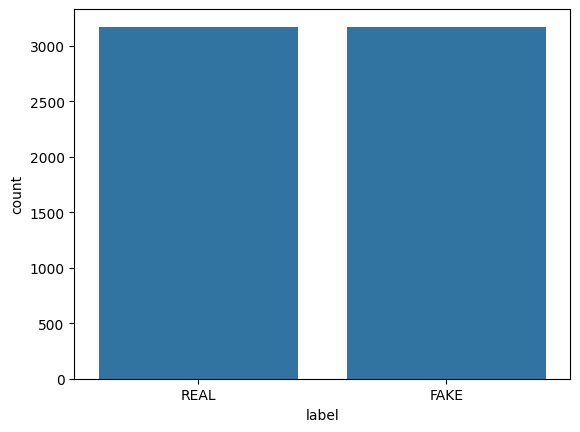

In [ ]:
# Шрафик наглядно покажет соотношение количества REAL и FAKE новостей в датасете
sns.countplot(data=df,
              x='label',
              order=df['label'].value_counts().index)

In [ ]:
# Данный блок необходим для предобработки текста
# Поможет удалить стоп-слова, знаки препинания и ненужные пробелы
# В блоке выше для этого подгружены и импортированы необходимые библиотеки
def preprocess_text(text_data):
  preprocessed_text = []

  for sentence in tqdm(text_data):
    sentence = re.sub(r'[^\w\s]', '', sentence)
    preprocessed_text.append(' '.join(token.lower()
                              for token in str(sentence).split()
                              if token not in stopwords.words('english')))

  return preprocessed_text

In [ ]:
preprocessed_review = preprocess_text(df['text'].values)
df['text'] = preprocessed_review

100%|██████████| 6335/6335 [09:54<00:00, 10.66it/s]


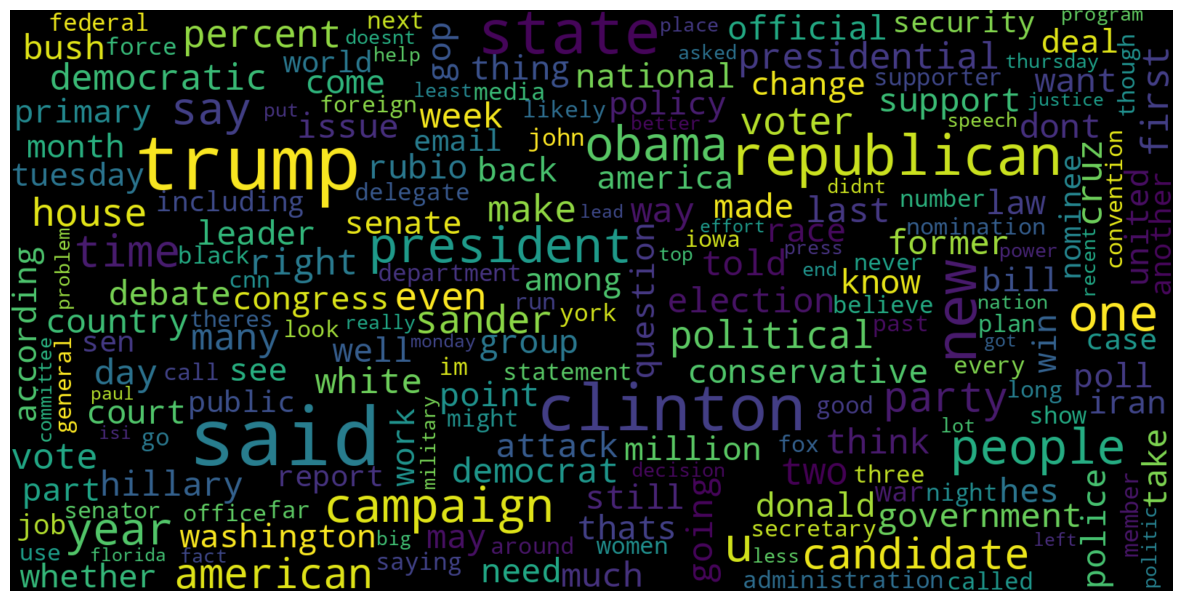

In [ ]:
# Данный блок кода выводит "облако тегов" - наиболее часто встречающиеся в тексте реальных новостей слова
consolidated = ' '.join(
  word for word in df['text'][df['label'] == 'REAL'].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

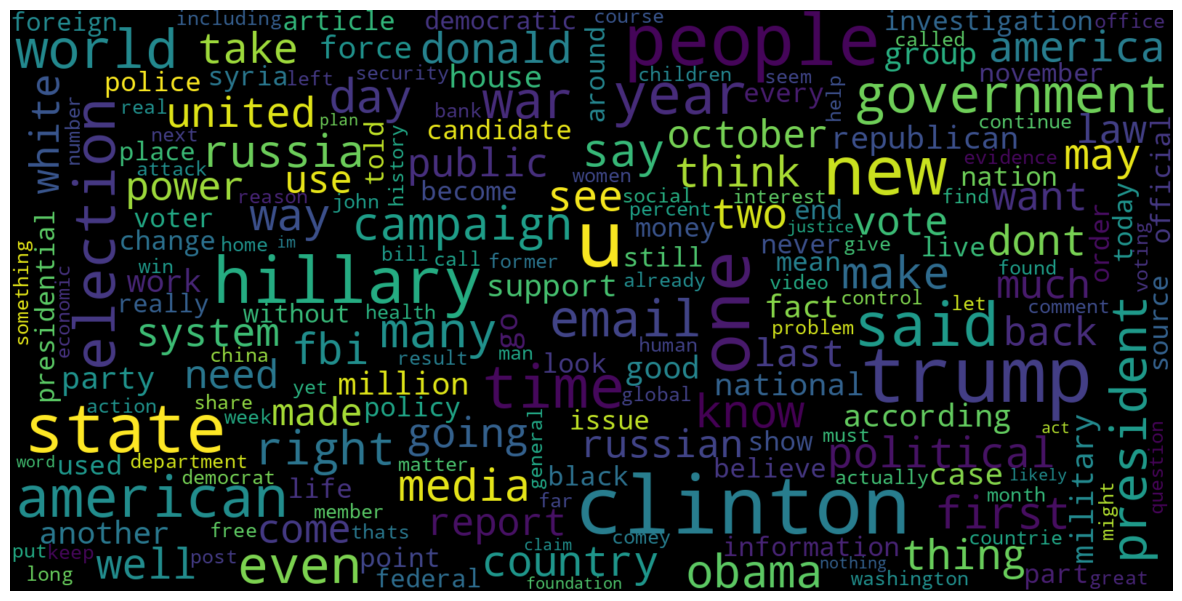

In [ ]:
# Здесь - облако слов фейковых новостей
consolidated = ' '.join(
  word for word in df['text'][df['label'] == 'FAKE'].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Гистограмма самых часто встречающихся слов'}, xlabel='Слово', ylabel='Количество'>

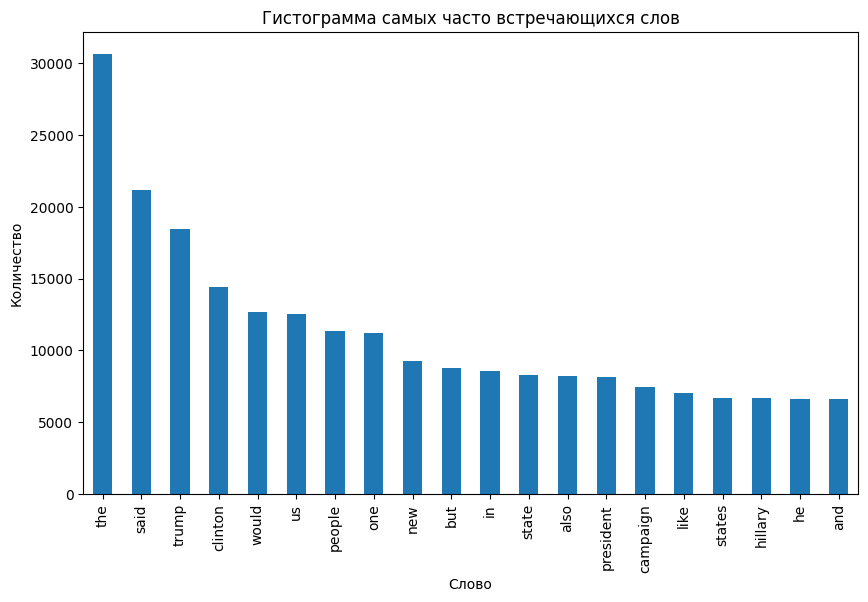

In [ ]:
# Диаграмма самых используемых слов

def get_top_n_words(corpus, n=None):
  vec = CountVectorizer().fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx])
                for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key=lambda x: x[1],
                      reverse=True)
  return words_freq[:n]


common_words = get_top_n_words(df['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
  kind='bar',
  figsize=(10, 6),
  xlabel="Слово",
  ylabel="Количество",
  title="Гистограмма самых часто встречающихся слов"
)

In [ ]:
# Здесь новости разделяются на обучающие и фейковые
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(df['text'],
                                                    df['label'],
                                                    test_size=0.25)

In [ ]:
# В этом блоке, с помощью TfidfVectorizer, обучающие данные преобразуются в векторы
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

In [ ]:
# При помощи accuracy_score оценивается точность прогнозирования при обучении пассивно-агрессивным классификатором
model = PassiveAggressiveClassifier()
model.fit(x_train, y_train)

# Тестирование модели
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

1.0
0.9356060606060606


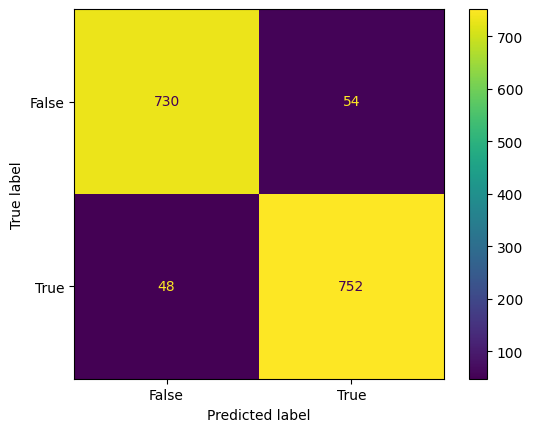

In [ ]:
# Строим матрицу ошибок
cm = metrics.confusion_matrix(y_test, model.predict(x_test))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])

cm_display.plot()
plt.show()